Net IDs: hak68, 

# Research Questions


How effective is diabetes care in the United States?

Based on how long a patient stays in hospital and how much they spent, can we predict what factors went into their care?


# Data collection and cleaning

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb


In [12]:
attributes_df = pd.read_csv("../info2950-final-project/Attribute_Description.csv")
medication_df = pd.read_csv("Medication_Data_Kaggle_V1.csv")
socio_eco_df = pd.read_csv("Socio_Economics_Data_Kaggle_V1.csv")
patient_data_training_df = pd.read_csv("Patient_Data_Training_Kaggle_V1.csv")

**Renaming column names to include no spaces for simpler selection**

In [43]:
def rename_column(colname):
  return colname.replace(' ', '_')

medication_df = medication_df.rename(mapper = rename_column, axis = 1)
socio_eco_df = socio_eco_df.rename(mapper = rename_column, axis = 1)
patient_data_training_df = patient_data_training_df.rename(mapper = rename_column, axis = 1)




# Data description

What are the observations (rows) and the attributes (columns)?

Each dataframe, medication_df, socio_eco_df, and patient_data_training_df are a part of the same larger set of data but split into different dataframes. This larger dataframe observed certain attributes for each diabetes patient, recognized by their unique patient id (each row is data for one patient). 

The patient_data_training_df has these attributes:
- SID: patient Unique ID
- Year: patient record year
- Age: patient age
- Race: patient race or ethnicity
- Sex: patient's sex
- State: state patient lives in
- Zip Code: patient zip code
- MSA: metropolitan statistical area code
- Enrollment Type Categorized: 
- Enrollment Months
- HCC Score
- Avg. LOS
- Diagnosis
- #Total Claims
- #Hospital OP
- #All Physician OP
- #Inpatient
- #Short Term Stay Hospital
- #Long Term Stay Hospital
- #Rehabilitation Hospital
- #Psychiatric Hospital
- #Readmissions
- #ER
- #ER Admissions
- #SNF
- #Non Swing Bed SNF Claim
- #Swing Bed SNF Claim
- #Home Health
- #Hospice
- #Labs
- #Part B Labs
- #Imaging
- #Part B Imaging
- #Part B E&M
- #Part B Drugs
- #Part B Ambulance
- #Dialysis
- #Part-B Dialysis
- #Rx Claims
- #DME
- #Miscellaneous
- TotalCost_Y_Actual
- TotalCost_Y_Expected

The medication_df has these attributes:

The socio_eco_df has these attributes: 




Why was this dataset created?

This data set was created to analyze the factors that go into diabetes care, the demographics of diabetes patients, and how much it cost these patients to get care.

Who funded the creation of the dataset?

What processes might have influenced what data was observed and recorded and what was not?


What preprocessing was done, and how did the data come to be in the form that you are using?


If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?


Where can your raw source data be found, if applicable?

# Data limitations

# Exploratory data analysis

Which medications are popular amoung diabetes patients?

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'dapagliflozin'),
  Text(1, 0, 'exenatide'),
  Text(2, 0, 'glimepiride'),
  Text(3, 0, 'glyburide and metformin hydrochloride'),
  Text(4, 0, 'insulin'),
  Text(5, 0, 'metformin hydrochloride'),
  Text(6, 0, 'pioglitazone'),
  Text(7, 0, 'sitagliptin and metformin hydrochloride')])

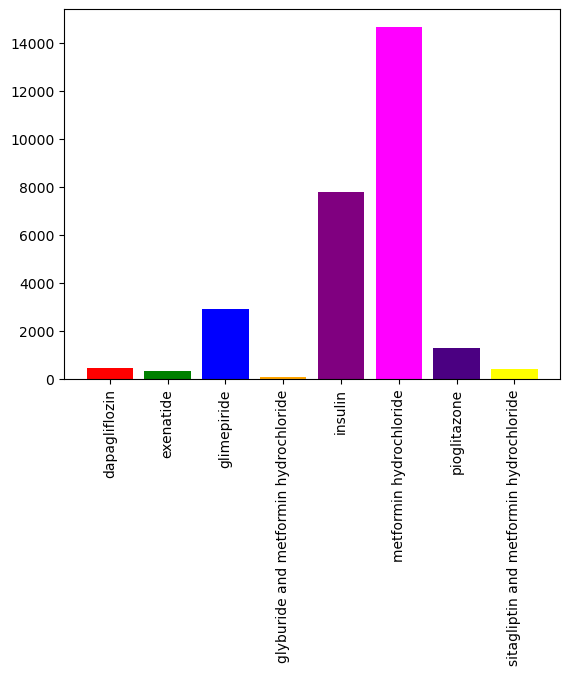

In [6]:
medication_df.head()
pop_med_df = np.sum(medication_df[['dapagliflozin', 'exenatide', 'glimepiride', 'glyburide and metformin hydrochloride', 'insulin', 'metformin hydrochloride', 'pioglitazone', 'sitagliptin and metformin hydrochloride']], axis = 0)


plt.bar(['dapagliflozin', 'exenatide', 'glimepiride',\
         'glyburide and metformin hydrochloride', 'insulin',\
         'metformin hydrochloride', 'pioglitazone',\
         'sitagliptin and metformin hydrochloride'],\
        pop_med_df,\
        color = ['red', 'green', 'blue', 'orange', 'purple', 'magenta', 'indigo', 'yellow'])
plt.xticks(rotation = 90)

Impact of quality of area on amount spent on diabetes care

Text(0, 0.5, 'Diabetes Care (\\$)')

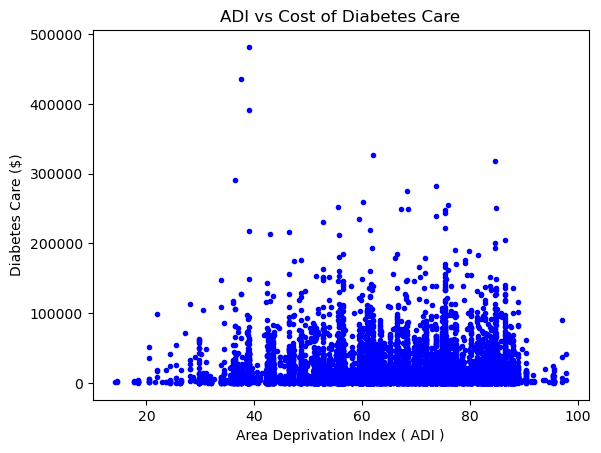

In [60]:
adi_vs_cost_df = duckdb.sql('SELECT socio_eco_df.ID, \
socio_eco_df.Avg_ADI, patient_data_training_df.TotalCost_Y_Actual AS Total_Cost \
FROM socio_eco_df \
INNER JOIN patient_data_training_df \
ON socio_eco_df.ID = patient_data_training_df.ID ').df()

plt.plot(adi_vs_cost_df['Avg_ADI'],adi_vs_cost_df['Total_Cost'],'b.')
plt.title('ADI vs Cost of Diabetes Care')
plt.xlabel('Area Deprivation Index ( ADI )')
plt.ylabel('Diabetes Care (\$)')

Which age-group gets diabetes the most?

[Text(0.5, 1.0, 'Diabetes by Age')]

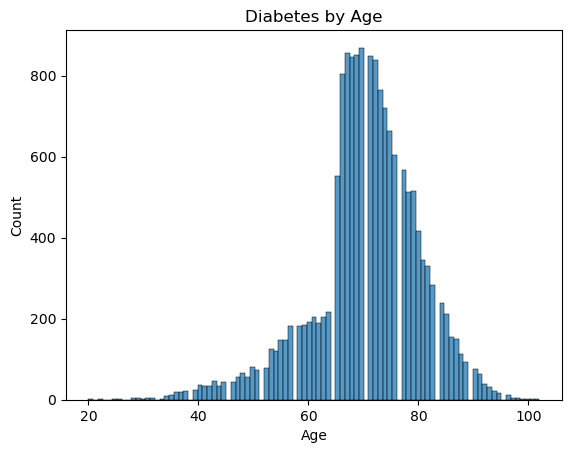

In [7]:
#min age = 20
#max age = 102

sns.histplot(patient_data_training_df[['Age']], x = "Age").set(title = "Diabetes by Age")


# Questions for reviewers